# <center>Exploration of normalization approaches</center>

This notebook contains the code to:
- Analyze ensembles' precision using different normalization approaches.
- Plot relative precision of each approach with respect to the baseline.

In [1]:
import os
from pathlib import Path
import sys

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append('../')
from src import analysis

PLOTS_PATH = '../data/plots'
PREDICTIONS_PATH = '../data/predictions'

mpl.rcParams['figure.dpi'] = 360
sns.set_style('whitegrid')

# Load precision results

In [2]:
norm_precision_fn = os.path.join(PREDICTIONS_PATH, "all_normalization_precision.csv")

if os.path.exists(norm_precision_fn):
    norm_precision = pd.read_csv(norm_precision_fn, sep="\t")
else:
    precision_files = [p for p in Path(PREDICTIONS_PATH).glob("precision_test-ensemble*-norm-exploration.csv")]

    norm_precision = pd.DataFrame([])
    for csv in precision_files:
        df = pd.read_csv(csv, sep="\t")
        ensemble = os.path.split(csv)[1].replace('precision_test-', '').replace('-norm-exploration.csv', '')
        df["ensemble"] = ensemble
        df["norm_fn"] = df["model"].apply(lambda x: x.replace('multi-', ''))
        df["model"] = df["norm_fn"]
        norm_precision = pd.concat([norm_precision, df], ignore_index=True)

    norm_precision.to_csv(norm_precision_fn, sep="\t", index=False)
    
norm_precision = norm_precision.drop(['tps_in_k', 'total_tps'], axis=1)

## Append results for average aggregation

In [3]:
avg_precision_fn = os.path.join('../data/predictions/', "all_avg_agg_precision.csv")
avg_precision = pd.read_csv(avg_precision_fn, sep="\t")

norm_precision = pd.concat([norm_precision, avg_precision])

In [4]:
baseline_precision = {}
baseline_norm = {'openbiolink': 'scores-perc95.0', 'biokg': 'scores-perc99.0'}
norm_fns = [fn for fn in norm_precision.norm_fn.unique()] #if fn != baseline_norm]


for kg in norm_precision.kg.unique():
    baseline_precision[kg] = {}
    for ensemble in norm_precision.ensemble.unique():
        baseline_precision[kg][ensemble] = {}
        for K in norm_precision.K.unique():
            df = norm_precision[
                (norm_precision['kg'] == kg) & \
                (norm_precision['ensemble'] == ensemble) & \
                (norm_precision['K'] == K) & \
                (norm_precision['norm_fn'] == baseline_norm[kg])
            ]
            
            assert len(df) == 1
            baseline_precision[kg][ensemble][K] = df['precision'].values[0]

In [5]:
norm_precision["precision_wrt_baseline"] = norm_precision.apply(
    lambda x: x['precision']/baseline_precision[x['kg']][x['ensemble']][x['K']], axis=1
)

# Plot precision

In [8]:
kg2title = {
    'openbiolink': 'OpenBioLink',
    'biokg': 'BioKG',
}


model2title = {
    'scores-all': 'Score Norm. (all)',
    'position-all': 'Position Norm. (all)',
    'scores-top5000': 'Score Norm. (Top5000)',
    'scores-perc95.0': 'Score Norm. (Percentile 95%)',
    'scores-perc99.0': 'Score Norm. (Percentile 99%)',
    'scores-perc99.9': 'Score Norm. (Percentile 99.9%)',
    'sigmoid-all': 'Sigmoid Norm. (all)',
    'sigmoid-norm-p99-perc99.0': 'Sigmoid Norm. (Percentile 99%)',
    'PoE': 'Product of Experts (PoE)',
}


def create_legend(palette):
    patches = []
    for model, color in palette.items():
        patch = mpatches.Patch(color=color, label=model)
        patches.append(patch)
    return patches
    

def plot_precision_barplot(
    df,
    baseline_model,
    xlim=None,
    ylim=None,
    title=None,
    nrows=2,
    ncols=1,
    width=1,
    figsize=(22,18),
    color_palette="hls",
    save_to=None
):
    df['model'] = df.model.apply(lambda x: model2title[x])
    df = df.sort_values(["kg", "model", "precision"], ascending=[False, False, False])
    K_values = df.K.unique()
    
    models = df.model.unique()
    palette_colors = sns.color_palette(color_palette, n_colors=len(models))
    palette = {m:c for m,c in zip(models, palette_colors)}
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if isinstance(baseline_model, str):
        baseline_model = [baseline_model, baseline_model]
        
    for i, (ax, kg) in enumerate(zip(axs, df.kg.unique())):

        sns.barplot(
            data=df[(df['kg'] == kg) & (df['model'] != baseline_model[i])],
            y='precision_wrt_baseline',
            x="K",
            hue='model',
            palette=palette,
            ax=ax,
        )
        
        baseline_color = palette[baseline_model[i]]
        
        ax.axhline(y = 1, color = baseline_color, linestyle = '-', linewidth=5)
        ax.set_title(kg2title[kg], y=1.0, pad=-20, fontsize=20)
        if ylim is not None:
            ax.set_ylim(ylim)
        else:
            ax.set_ylim(bottom=0)
        ax.set_xlabel('Top K', fontsize=20)
        ax.set_ylabel('Precision@K wrt. baseline', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.legend().remove()
        
    legend = axs[1].legend(
        title="Model",
        title_fontsize=20,
        loc='lower center',
        fancybox=True,
        handles=create_legend(palette),
        fontsize=16,
        bbox_to_anchor=(0.5, -0.3),
        ncol=5,
    )
    
    plt.tight_layout()
    plt.subplots_adjust(
        hspace=0.2,
    )
    
    if title is not None:
        fig.suptitle(title, fontsize=25, y=1.0)

    if save_to is not None:
        plt.savefig(os.path.join(PLOTS_PATH, save_to), dpi=360, bbox_inches='tight')

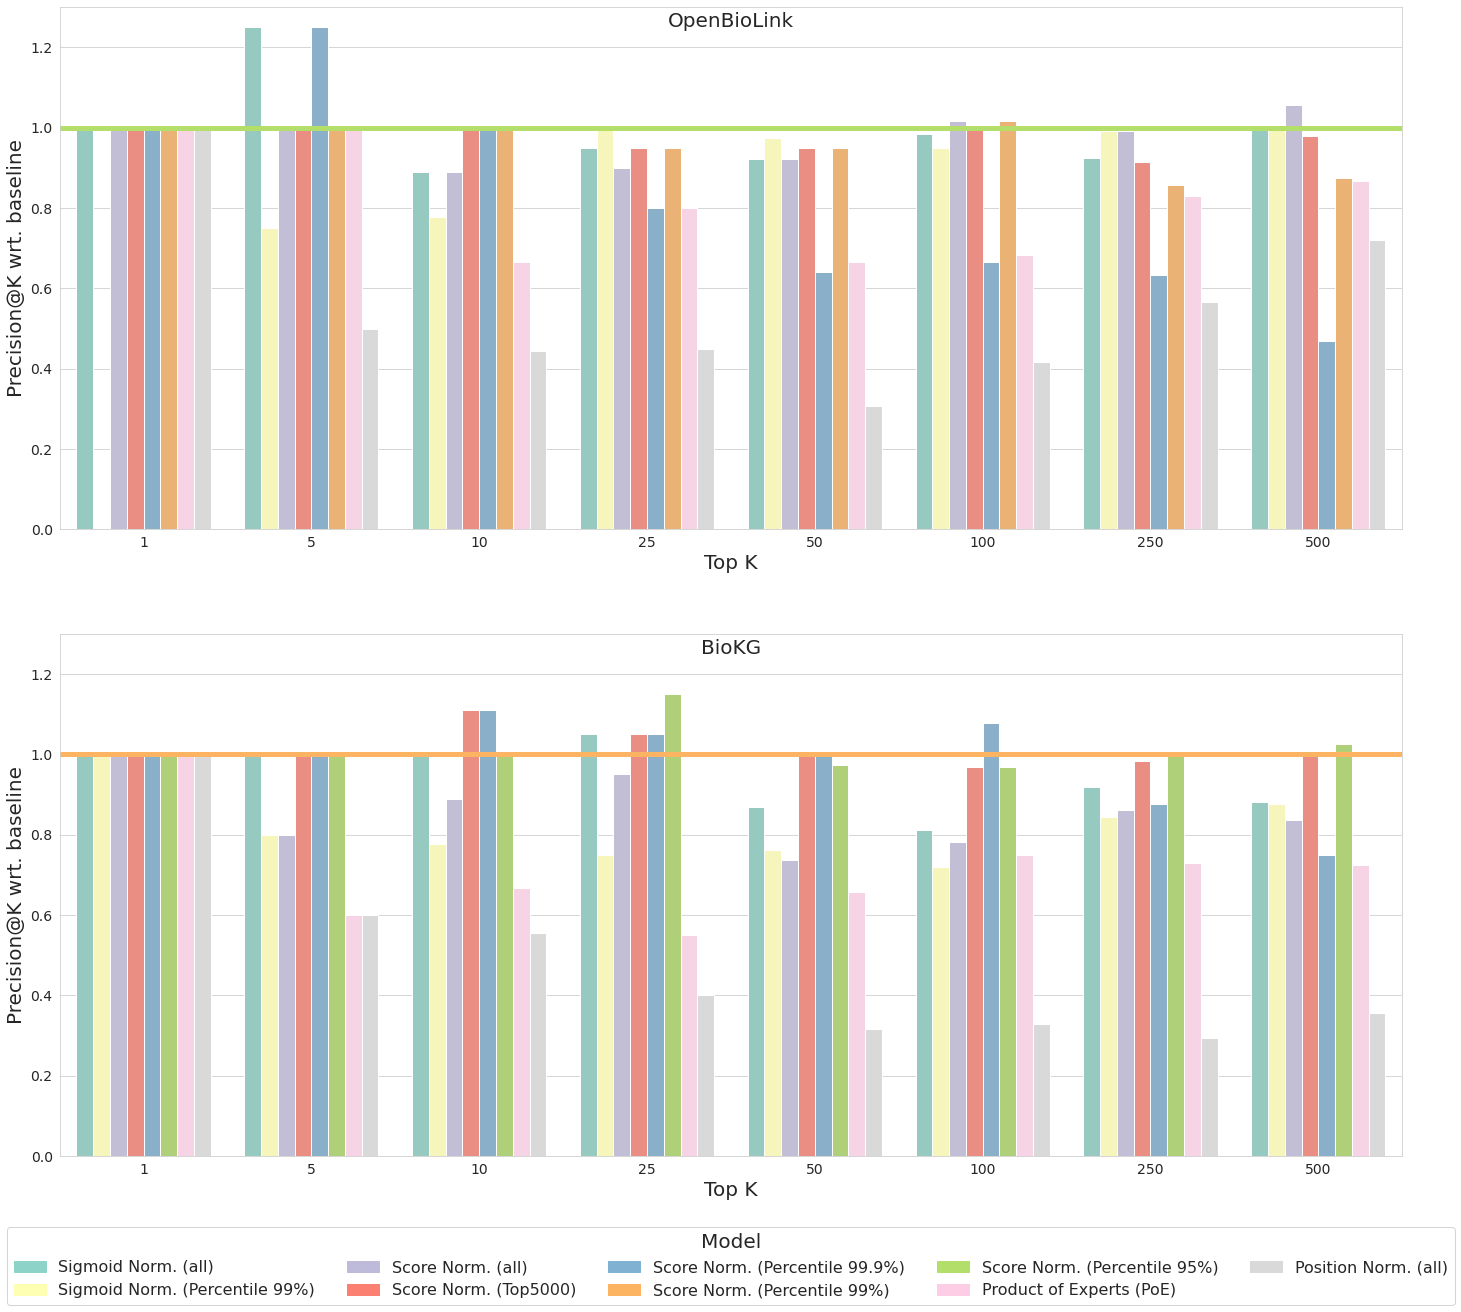

In [9]:
exclude_norm_fns = [
    "sigmoid-shifted-all",
    "sigmoid-0centered-all",
    "sigmoid-avgcentered-all",
    "scores-top500",
    "scores-top1000",
    "scores-avg",
]

include_norm_fns = [
    fn
    for fn in norm_precision.norm_fn.unique()
    if fn not in exclude_norm_fns
]

plot_precision_barplot(
    norm_precision[norm_precision['model'].isin(include_norm_fns)].copy(),
    baseline_model=['Score Norm. (Percentile 95%)', 'Score Norm. (Percentile 99%)'],
    save_to="normalization_wrt_baseline.png",
    ylim=(0,1.3),
    color_palette="Set3",
)